In [1]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [2]:
documents = WikipediaLoader(query="tennessee state information").load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

split_documents = text_splitter.split_documents(documents)

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vector_store = InMemoryVectorStore(embedding=embeddings)

vector_store.add_documents(split_documents)

['c24d481a-01d3-41cf-afa7-4f42451a1ecd',
 '680a0a6c-001c-4af7-9cf5-ff6bd6941d59',
 '84a0cd8a-8483-4e69-bdf6-e06a3c7980b6',
 '670325ef-76a0-401c-941f-b03d6cfa3f18',
 'c8d9db26-005e-4277-9906-f6f36c215da4',
 'ec7de5c8-99ee-450c-8021-ab2f23a7a77c',
 'ec1c7ff2-fc45-451e-96c6-3ee7e205b3ec',
 'a6d9dfd1-4fbc-4e73-b642-1b4b4d38341f',
 'db7f1eb9-2caf-4d0a-aff3-af90dc50e082',
 '59b575c7-e6f0-4b57-a163-23e99849e2b1',
 'bbb7b00d-6c3e-4480-9520-f13cac6d1d4f',
 'a690a0a4-6cf1-4f99-a74a-f088f42bc664',
 '392f9070-c959-4760-bee7-f336d885078c',
 'd420d04a-9e7e-4a8e-b48b-a692573fe16c',
 'de845cbc-5fa6-4f8e-9e09-32e2a463acbd',
 '5491aed4-bf49-4e0e-821d-d627ca8cbd5f',
 'd63a1f7f-ee65-4829-b1cc-52ae8b81814d',
 '0dba554c-84cc-4d88-8022-553862644547',
 '4733bf46-5b17-469d-82c5-5b9b7d8bd8e6',
 '11722664-0e89-46c0-8ebd-c0821d0beb3a',
 '6e2c8f9d-d316-4c07-8c66-aee984a2664e',
 'faefdb44-54c8-4855-979f-89922f5c6c95',
 '26414daa-f742-47ca-9bf9-f98323debdc8',
 '8dd5bd61-f153-4ee1-b56a-d24c57c375a4',
 '6197416d-1354-

In [3]:
retriever = vector_store.as_retriever()

In [4]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    name="retrieve_tennessee_documents",
    description="Search and return information about Tennessee. This tool does not return information about other States.",
)

tools = [retriever_tool]

In [5]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    description="Only use this search tool when other tools cannot provide the answer."
)

tools.append(tavily_search_tool)

In [6]:
from typing import Annotated, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [7]:
from typing import Literal

from langchain_core.messages import HumanMessage
from pydantic import BaseModel, Field


def grade_documents(state) -> Literal["generate", "rewrite"]:
    print("---CHECK RELEVANCE---")

    class grade(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    llm_with_tool = llm.with_structured_output(grade)

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    input_message_text = (
        "You are a grader assessing relevance of retrieved documents to a user question. "
        f"context: {docs}"
        f"question: {question}"
        "If the documents contain keywords or semantic meaning related to the user question, grade them as relevant. "
        "Give a binary score of a 'yes' or 'no' to indicate whether the document is relevant to the question."
    )

    messages = [HumanMessage(content=input_message_text)]

    scored_result = llm_with_tool.invoke(messages)

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        print(score)
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [8]:
def agent(state):
    print("---CALL AGENT---")
    messages = state["messages"]
    llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [9]:
def rewrite(state):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    message = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent/meaning. \n
    Here is the initial question:
    \n ------ \n
    {question}
    \n ------ \n
    Formulate an improved question: """,
        )
    ]

    llm = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = llm.invoke(message)
    return {"messages": [response]}

In [10]:
from langchain_core.messages import SystemMessage


def generate(state):
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    system_prompt_message = (
        "You are an assistant for question & answering tasks. "
        "Use the following pieces of retrieved context to answer the question. "
        "If you don't know the answer, then politely say that you do not know the answer. "
        "Use a maximum of three sentences and keep answers concise. "
    )

    system_message = SystemMessage(content=system_prompt_message)

    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    messages = [system_message, HumanMessage(f"question: {question}\ncontext: {docs}")]

    response = llm.invoke(messages).content

    return {"messages": [response]}

In [11]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(AgentState)

# Add nodes to our graph
workflow.add_node("agent", agent)
tool_node = ToolNode([retriever_tool, tavily_search_tool])
workflow.add_node("tools", tool_node)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

# We start with agent
workflow.add_edge(START, "agent")

# This is where we determine if we a made a tool call
workflow.add_conditional_edges(
    "agent",
    # Did the agent call or a tool or not?
    tools_condition,
    {
        # If we did call a tool, then use the tool
        # If not, then we generate
        "tools": "tools",
        END: END,
    },
)

# If we retrieved documents, then we grade them.
# grade_documents determines where we go next based on the score: generate or rewrite
workflow.add_conditional_edges(
    "tools",
    grade_documents,
)

# If we called a tool, then we call generate.
workflow.add_edge("generate", END)
# If we need to rewrite, then we call the agent again
workflow.add_edge("rewrite", "agent")

# Compile our workflow
graph = workflow.compile()

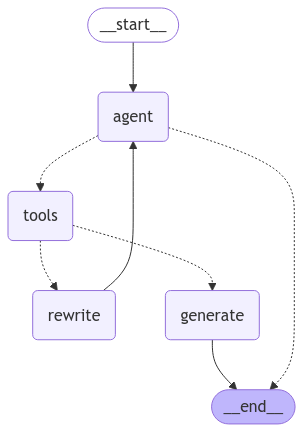

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
import pprint

input_messages = {
    "messages": [HumanMessage(content="How many people reside in Tennessee?")]
}

for output in graph.stream(input_messages):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("---")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_uUPUI1kvCq5Ms6riXD7n7WFB', 'function': {'arguments': '{"query":"population of Tennessee"}', 'name': 'retrieve_tennessee_documents'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-62b39c22-4a41-4d78-9f07-cc03b63a66fd-0', tool_calls=[{'name': 'retrieve_tennessee_documents', 'args': {'query': 'population of Tennessee'}, 'id': 'call_uUPUI1kvCq5Ms6riXD7n7WFB', 'type': 'tool_call'}])]}
'---'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
yes
"Output from node 'tools':"
'---'
{ 'messages': [ ToolMessage(content="Tennessee ( , locally ), officially the State of Tennessee, is a landlocked state in the Southeastern region of the United States. It borders Kentucky to the north, Virginia to the northeast, North Carolina to the east, G

In [14]:
input_messages = {
    "messages": [HumanMessage(content="How many people reside in Alabama?")]
}

for output in graph.stream(input_messages):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("---")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_vTfjwIkjFPdVoOwLaXT52HUO', 'function': {'arguments': '{"query":"current population of Alabama 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-29938f08-77fd-42be-af44-657446b3adbc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current population of Alabama 2023'}, 'id': 'call_vTfjwIkjFPdVoOwLaXT52HUO', 'type': 'tool_call'}])]}
'---'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
yes
"Output from node 'tools':"
'---'
{ 'messages': [ ToolMessage(content='[{"url": "https://www.alabama-demographics.com/", "content": "Get the Alabama demographic data that you need. You can get the most current Alabama data from the US Census Bureau without spending 40 high-

In [15]:
input_messages = {
    "messages": [HumanMessage(content="What is the tallest mountain in the US?")]
}

for output in graph.stream(input_messages):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("---")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='The tallest mountain in the United States is Denali, also known as Mount McKinley, which is located in Alaska. Denali has a peak that rises to 20,310 feet (6,190 meters) above sea level, making it the highest peak in North America.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-bb56f425-065f-486e-9a7b-8b347a496eb6-0')]}
'---'
